For a  "case k" interval censored data, we only know that survival time $T$ has occurred within some random time interval $[L,R]$. Let $T_i$ be the $i$ th subject’s unobservable failure time, and $[L_i,R_i]$.

The likelihood function has the form 
$$L(\boldsymbol{\beta})=\prod_{i=1}^n \left[\exp\{-\Lambda_0(L_i)e^{\boldsymbol{\beta}^{\prime}\mathbf{Z}_i}\}-\exp\{-\Lambda_0(R_i)e^{\boldsymbol{\beta}^{\prime}\mathbf{Z}_i}\}\right],$$
where $\Lambda_0(t)=\int_{0}^t \lambda_0(s) d s$, the cumulative baseline hazard function. 

For simplicity, let $\lambda_0(t)=1$.

In [1]:
# generate CoxPH model data
import numpy as np
import numpy.random as rd


def make_phaz_data(n, coef, rho=0.3, lam=10, time=3, seq=10):
    p = coef.shape[0]
    mu = np.zeros(p)
    # interval
    #a = np.random.uniform(0,time, seq)
    #a=np.append(np.array(0), np.sort(a))
    #a=np.append(a,time)
    a=np.linspace(0, time, seq)   # fixed
    #print(a)

    L = np.zeros(n)   # left of the censoring intervals
    R = np.zeros(n)   # right of the censoring intervals
    # Sigma = np.power(rho, np.abs(np.arange(p) - np.arange(p).reshape(p, 1)))
    Sigma = np.diagflat(np.ones(p))
    x = rd.multivariate_normal(mu, Sigma, (n,))    # variables
    xcoef = np.matmul(x, coef)
    #print(np.max(xcoef))
    T = -np.log(rd.uniform(0, 1, (n,)))/(lam*np.exp(xcoef))   # survival time
    #print(T)
    print("The maximum survival time of the sample is:", np.max(T))
    if(np.max(T)>time):
        print("The observation time is too short, please change a larger time")
        return(0)
    else:
        for i in range(n):
            index = np.where((a>T[i]))[0][0]
            L[i] = a[index-1]
            R[i] = a[index]
        return x, L, R

In [2]:
import jax.numpy as jnp

def phazard_objective(params):
    xcoef = jnp.matmul(x, params)
    #print(xcoef)
    #print(jnp.exp(xcoef))
    #print(jnp.exp(-lam*jnp.multiply(L,jnp.exp(xcoef)))-jnp.exp(-lam*jnp.multiply(R,jnp.exp(xcoef))))
    return -jnp.mean(jnp.log(jnp.exp(-lam*jnp.multiply(L, jnp.exp(xcoef)))-jnp.exp(-lam*jnp.multiply(R,jnp.exp(xcoef)) )))

/Users/zhujin/miniforge3/envs/convex-solver/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


The maximum survival time of the sample is: 5.207315063716993
1.0101010101010102


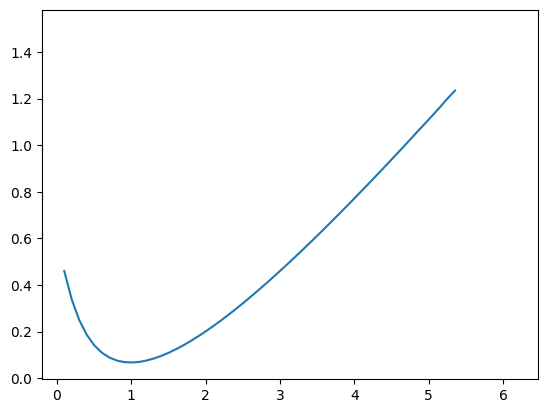

In [3]:
import matplotlib.pyplot as plt

# generate data 
n, p, k, lam = 200, 1, 1, 20
np.random.seed(1234)
beta = np.zeros(p)
beta[np.linspace(0, p - 1, k, dtype=int)] = [1 for _ in range(k)]
x, L, R = make_phaz_data(n,beta,lam=20,time=10,seq=20)

# plot (one dimension)
coef = np.linspace(0, 10, 100)
y = np.zeros_like(coef)
for i in range(len(y)):
    y[i] = phazard_objective(np.array([coef[i]]))
plt.plot(coef,y)
print(coef[np.argmin(y)])

The maximum survival time of the sample is: 1.5293941070253876
[1. 0.]


/var/folders/rz/hg01ch5s7xv_0tm2_nww6l8r0000gn/T/ipykernel_9215/1371333187.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter3D(xlab,ylab,zlab, cmap='Blues')


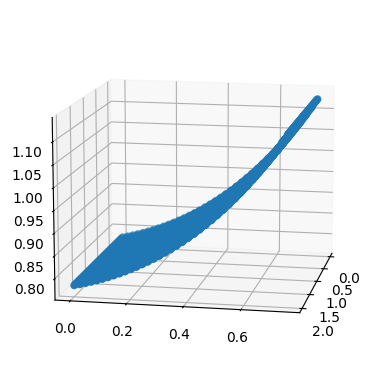

0

In [4]:
# generate data 
n, p, k, lam = 200, 2, 1, 20

np.random.seed(1234)
beta = np.zeros(p)
beta[np.linspace(0, p - 1, k, dtype=int)] = [1 for _ in range(k)]
x, L, R = make_phaz_data(n, beta, lam=10, time=5, seq=10)


# plot( two dimensions)
import matplotlib.pyplot as plt
print(beta)
xlab = np.repeat(np.linspace(0, 2, 100), 100)
ylab = np.tile(np.linspace(0, 2, 100), 100)
zlab = np.zeros_like(xlab)
for i in range(100):
    for j in range(100):
        #print(np.array([xlab[i],ylab[j]]))
        zlab[100*i+j] = phazard_objective(np.array([xlab[i], ylab[j]]))
fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.scatter3D(xlab,ylab,zlab, cmap='Blues')
ax1.view_init(elev=12, azim=11)
plt.show()

np.argmin(zlab)

In [5]:
from scope import ScopeSolver

# generate data 
n, p, k = 200, 2, 1

np.random.seed(1234)
beta = np.zeros(p)
beta[np.linspace(0, p - 1, k, dtype=int)] = [1 for _ in range(k)]
x, L, R = make_phaz_data(n,beta,lam=10,time=5,seq=10)


solver = ScopeSolver(p, k)
solver.solve(phazard_objective, jit=True, init_params=np.ones(p))

#print("Estimated parameter:", solver.get_result()["params"], "objective:",solver.get_result()["value_of_objective"])
print("Estimated parameter:", solver.get_result()["params"], "objective:",solver.get_result()["value_of_objective"])
print("True parameter:", beta, "objective:",phazard_objective(beta))


The maximum survival time of the sample is: 1.5293941070253876


: 

: 

### Reference

<div id="refer-1"></div>

- [1] Huang J, Wellner J A. Interval censored survival data: a review of recent progress[C]//Proceedings of the first Seattle symposium in biostatistics: survival analysis. Springer US, 1997: 123-169.

<div id="refer-2"></div>

- [2] Du, M., and Sun, J. (2022) Variable Selection for Interval-censored Failure Time Data. International Statistical Review, 90: 193– 215. https://doi.org/10.1111/insr.12480.